In [2]:
import shap 
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split
import seaborn as sns

import src.modules as modules

In [3]:
%load_ext autoreload
%autoreload 2

# Import data
Here we use differentially expressed i.e. |ESR1|>0.5

In [4]:
df = pd.read_pickle("/data/severs/clean_cancer_old.pkl")

In [33]:
np.where(df.columns=="ESR1")

(array([5051]),)

In [5]:
Y = df.ESR1[abs(df.ESR1)>0.5]

In [6]:
X = df.loc[abs(df.ESR1)>0.5].drop("ESR1", axis=1)

In [7]:
Xd = xgb.DMatrix(X, label=Y)



In [8]:
train_index_diff = pd.read_csv('/data/severs/trainind_patient_strat_diffexp.csv')["Resample1"].values -1

In [9]:
test_index_diff = np.zeros(691, dtype=int)
i = 0
for idk in range(X.shape[0]):
    if idk not in train_index_diff:
        test_index_diff[i] = idk
        i += 1

In [10]:
# import patient numbers for differentially expressed cells
import csv
with open('/data/severs/BP_patientnumber_diffexp.csv', newline='') as f:
    reader = csv.reader(f)
    tmp = list(reader)
    
    patient_number = list()
    for line in tmp:
        sl = line[0].split("] ")[1].split(" ")
        for s in sl:
                patient_number.append(int(s))

## Building model

The models vary very little with different parameters

In [149]:
params = {
        'eta' : 0.05, 
        'max_depth' : 6,
        'n_estimators':200,
        'subsample' : 1, 
        'colsample_bytree' : 1,
        'eval_metric' :  'rmse',
        'n_jobs' : 30
}

In [68]:
model =  xgb.XGBRegressor(**params)

In [ ]:
train_hist = model.fit(X.iloc[train_index_diff], Y[train_index_diff],verbose=10)

[16:58:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




#### Test model

In [22]:
prediction = model.predict(X.iloc[test_index_diff])

R^2 score is not well-defined with less than two samples.


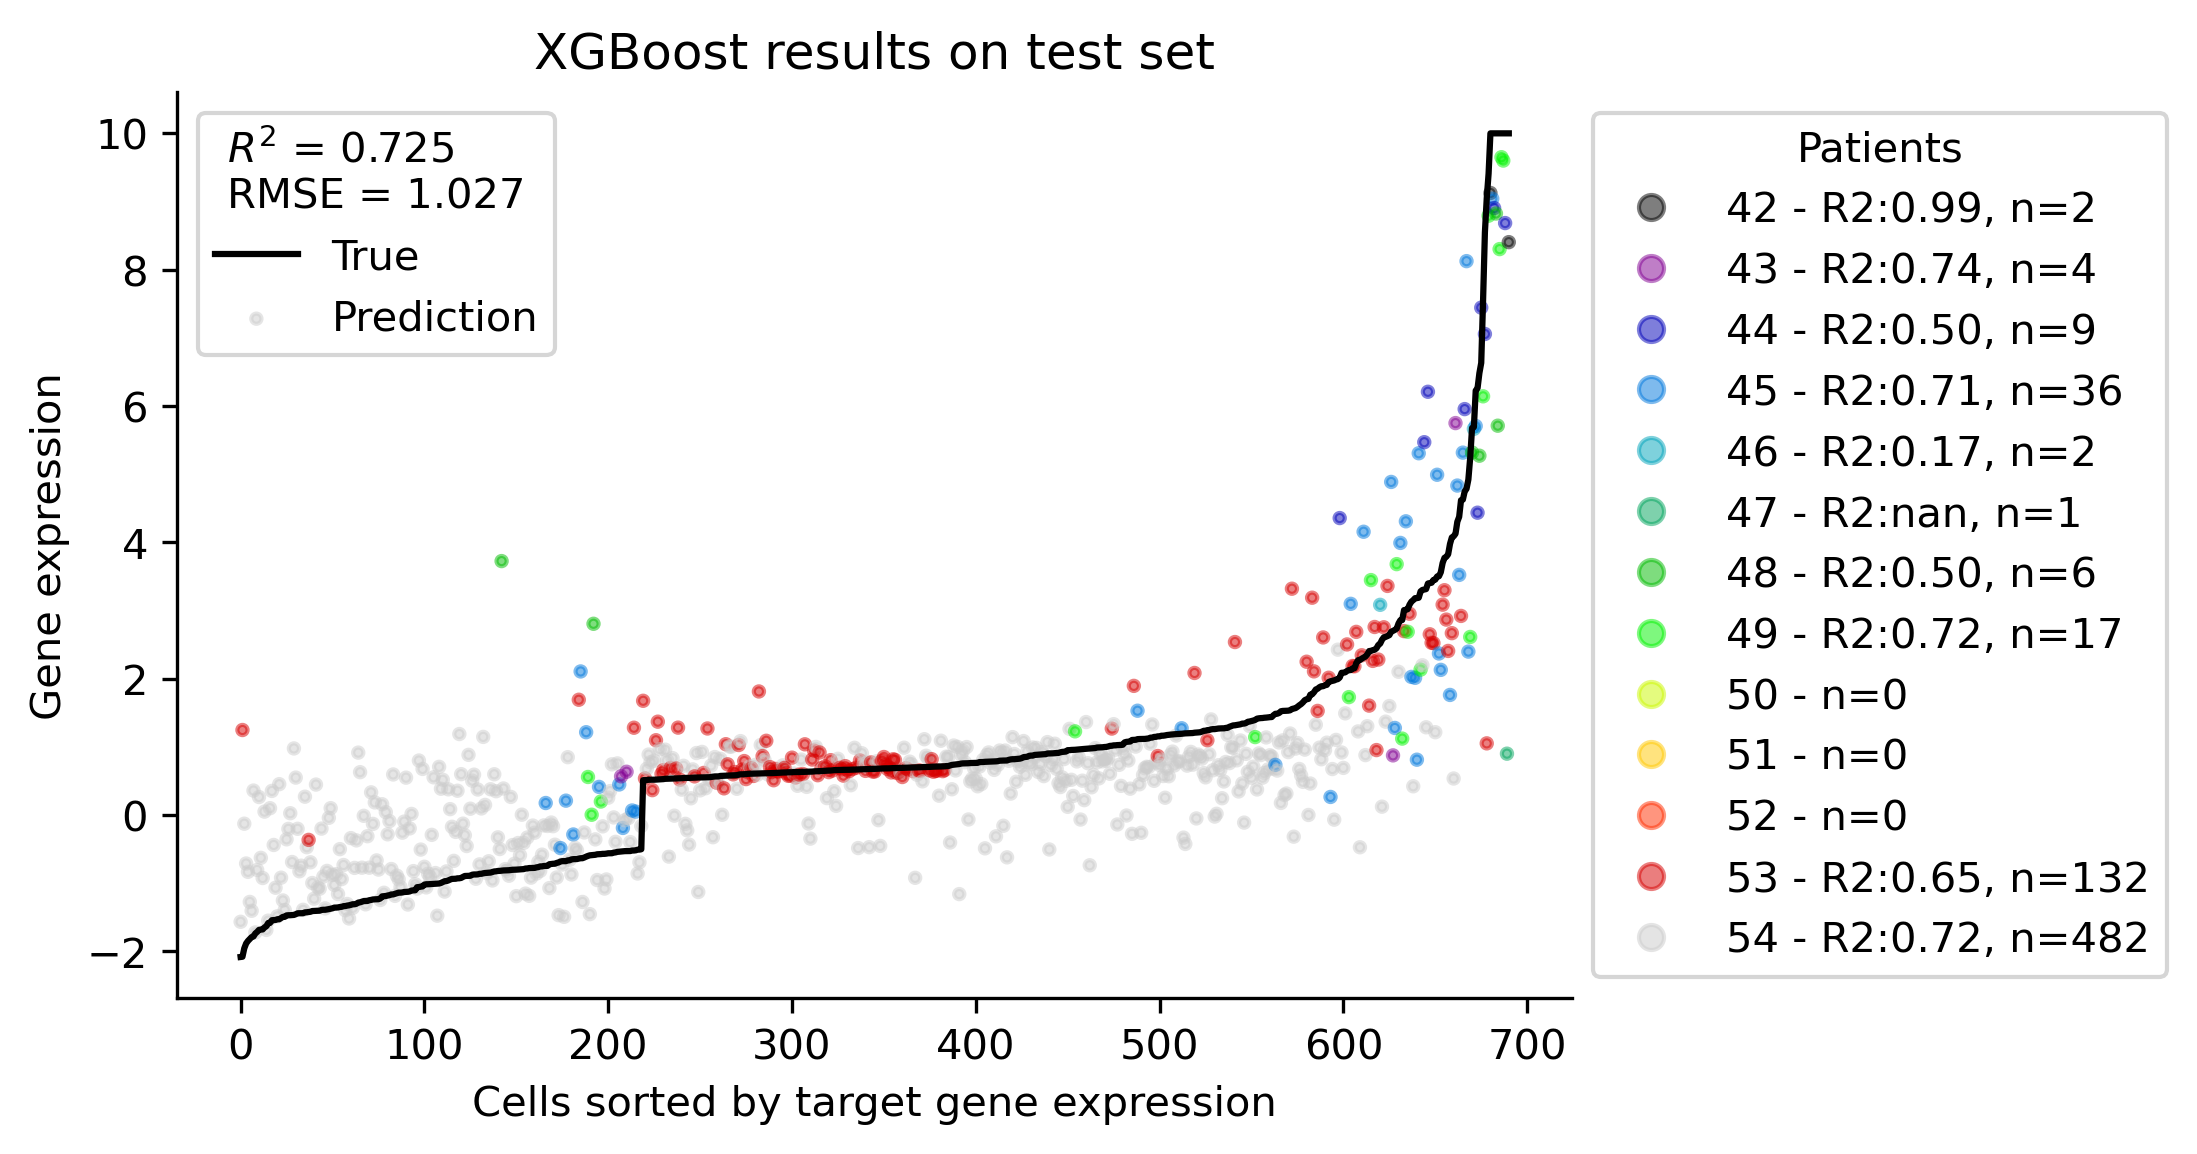

In [286]:
fig, ax = plt.subplots(dpi=300)
modules.plot_prediction(Y[test_index_diff], 
                        prediction,
                        c=np.array(patient_number)[test_index_diff],
                        cmap="nipy_spectral",
                        fig=fig, ax=ax, title="XGBoost results on test set")
plt.show()

## Save and load model

In [159]:
model.save_model("/data/severs/xgb_model_diff.model")

In [24]:
bst = xgb.Booster({'nthread': 40})  # init model
bst.load_model('/data/severs/xgb_model_diff.model')  # load data

The loaded model requires the DMatrix format to make predictions

In [25]:
# Make data compatible for cv and loaded models
training_dmatrix = xgb.DMatrix(X.iloc[train_index_diff], label=Y[train_index_diff])
test_dmatrix = xgb.DMatrix(X.iloc[test_index_diff], label=Y[test_index_diff])

In [26]:
prediction_bst = bst.predict(test_dmatrix)

In [27]:
def patient(p):return (np.array(patient_number)[test_index_diff]==p)

R^2 score is not well-defined with less than two samples.


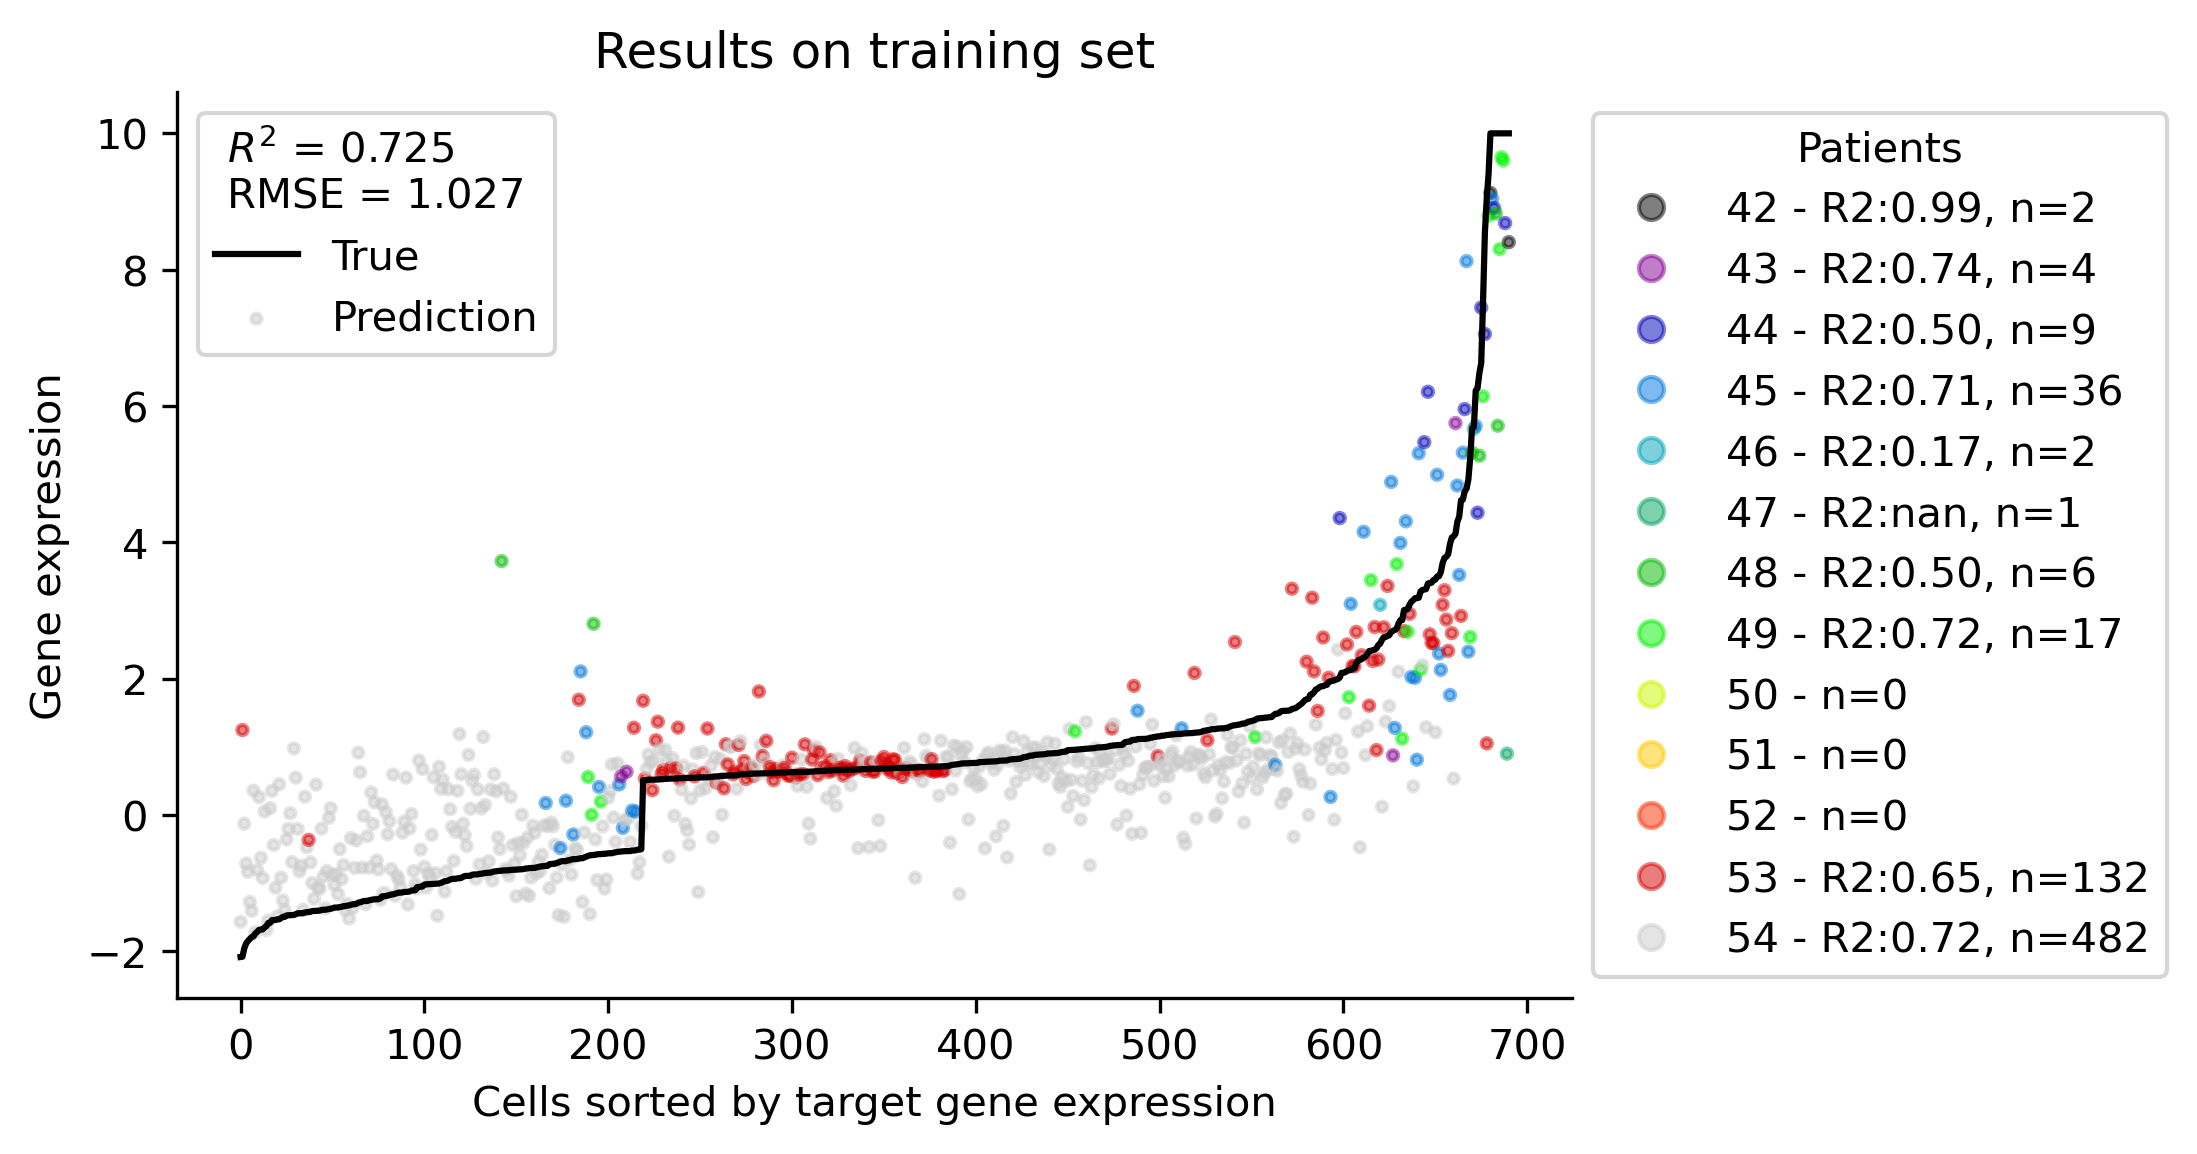

In [29]:
# Saved and loaded models makes the same predictions

fig, ax = plt.subplots(dpi=300)
modules.plot_prediction(Y[test_index_diff], 
                        prediction_bst,
                        c=np.array(patient_number)[test_index_diff],
                        cmap="nipy_spectral",
                        fig=fig, ax=ax, title=f"Results on training set")
plt.show()

# Shapley analysis

It is hard to interpret the most non linear effects like EPHA1-AS1 having such a big impact because it is very close to zero for almost all cells. 

In [30]:
explainer = shap.TreeExplainer(bst)



In [31]:
explainer = shap.TreeExplainer(bst)
shap_vals = explainer.shap_values(X)

In [302]:
def patient_(p):return (np.array(patient_number)==p)

In [304]:
patient_(53)

array([False, False, False, ..., False, False, False])

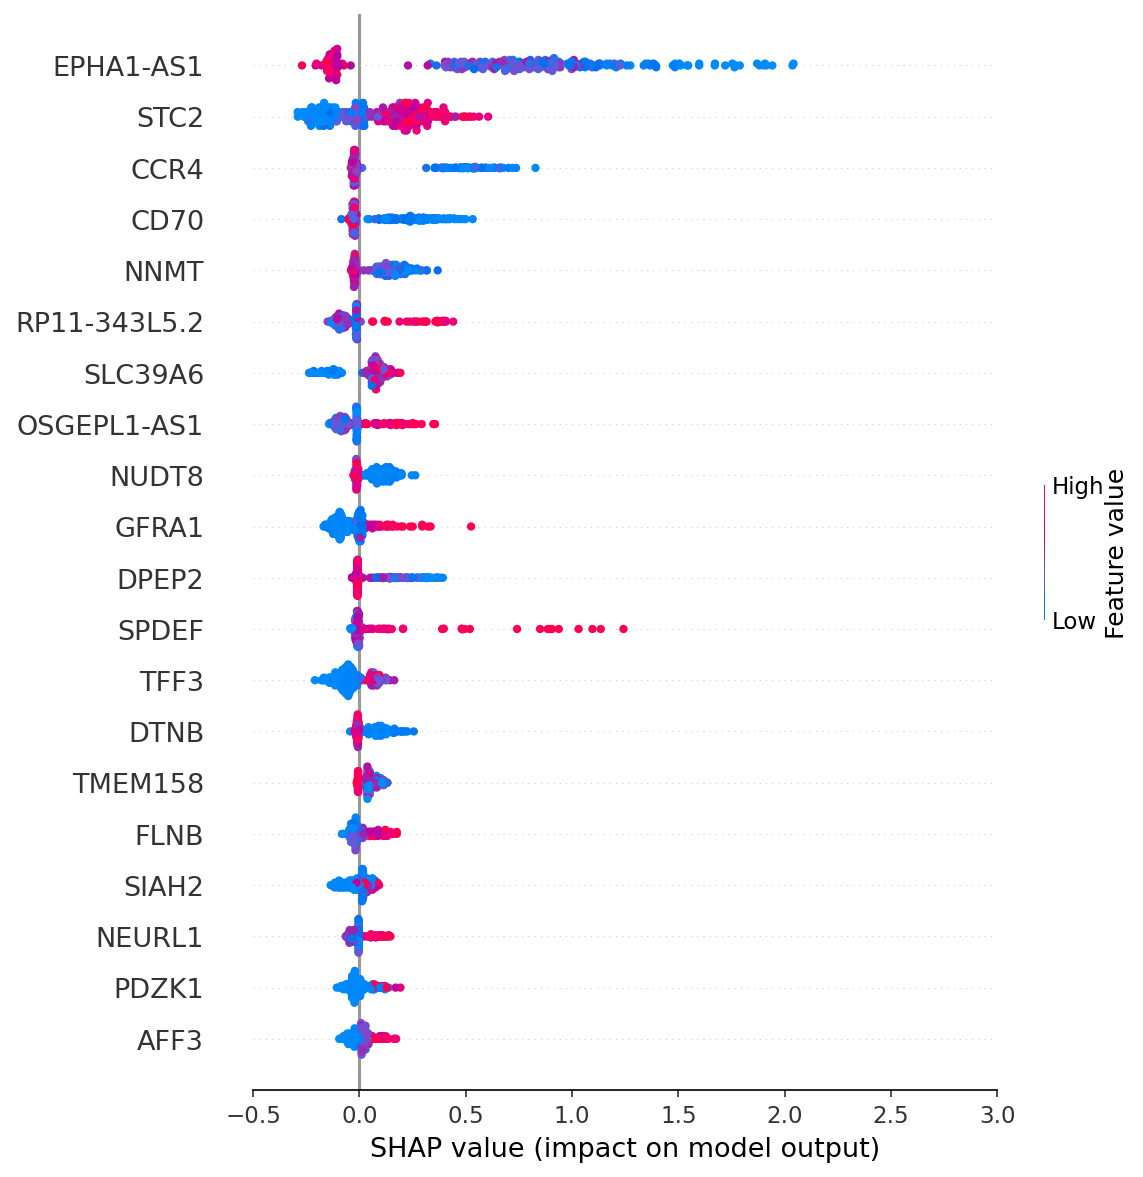

In [315]:
plt.figure(dpi=150)
p=45
plt.xlim((-0.5, 3))
shap.summary_plot(shap_vals[patient_(p)], X.iloc[patient_(p)])


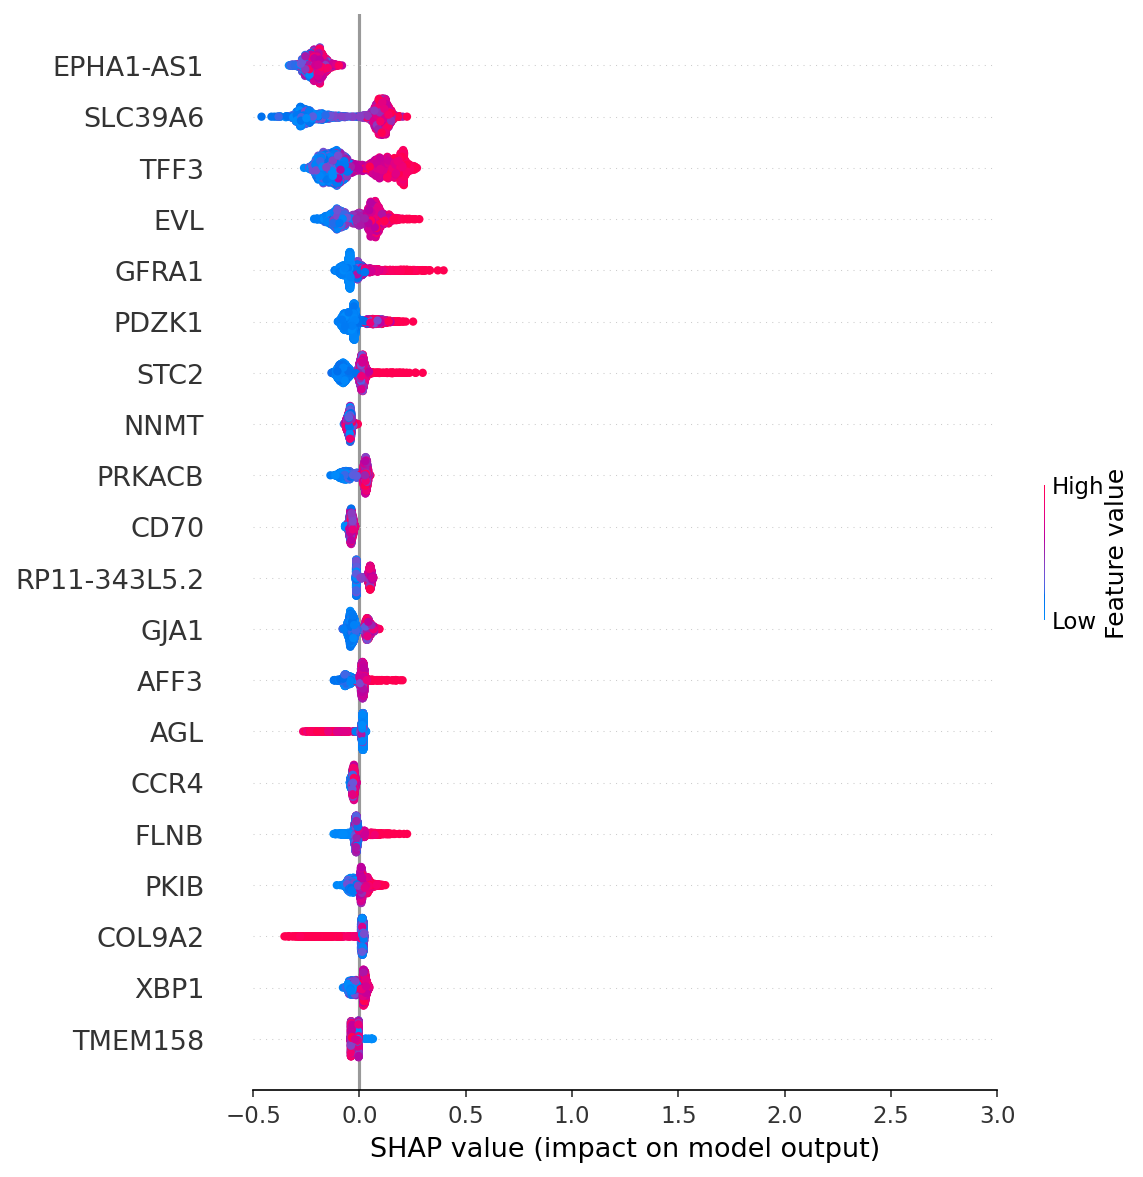

In [318]:
plt.figure(dpi=150)
p=54
plt.xlim((-0.5, 3))

shap.summary_plot(shap_vals[patient_(p)], X.iloc[patient_(p)], color_bar=True)

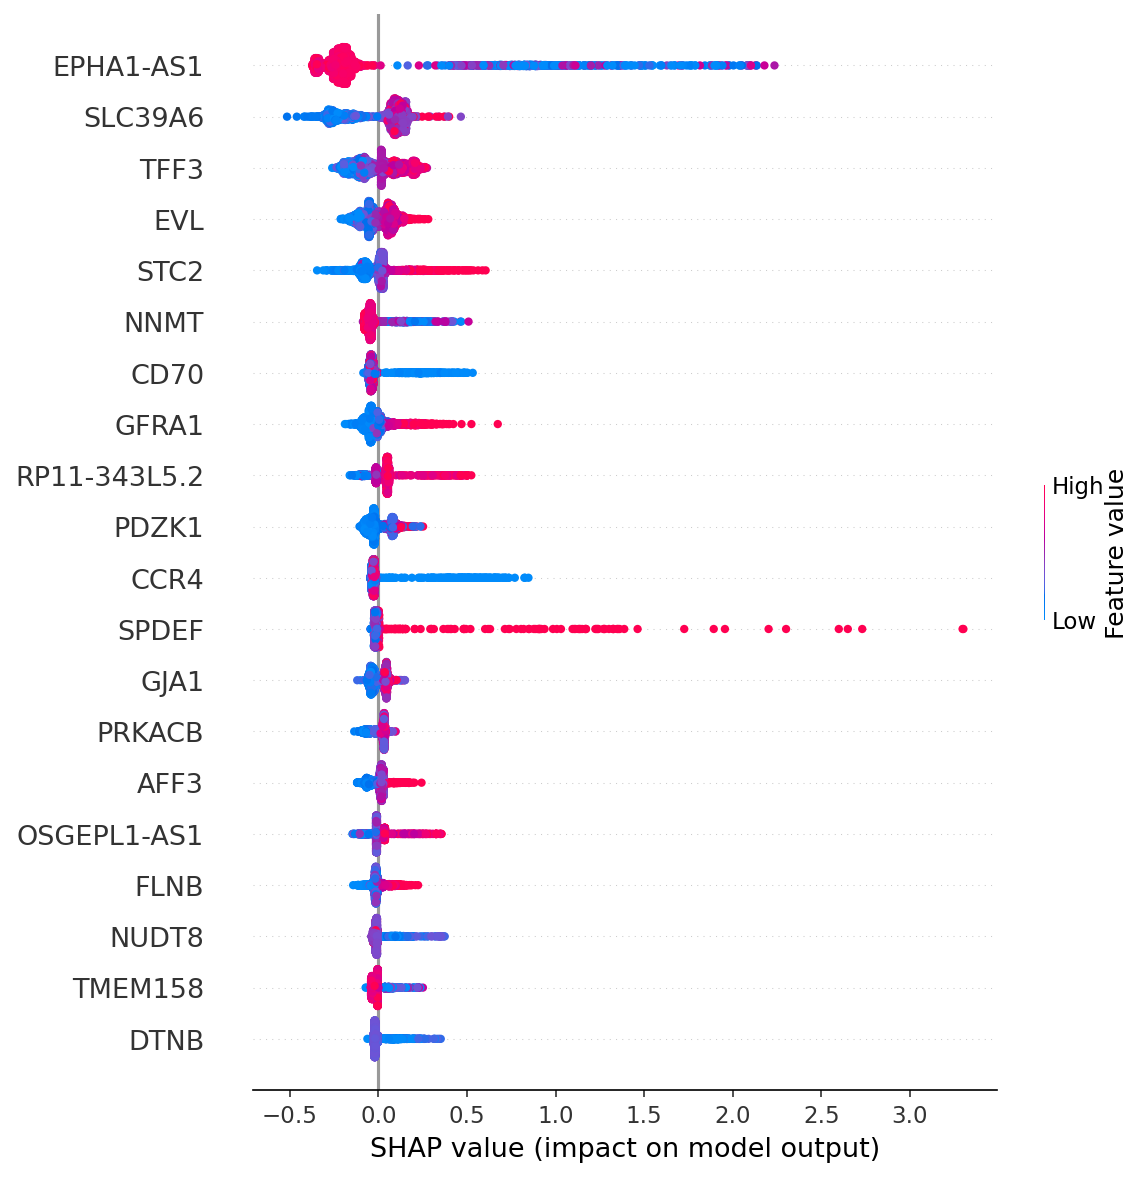

In [320]:
plt.figure(dpi=150)
p=45
shap.summary_plot(shap_vals, X)



In [35]:
abs_mean_shap = np.abs(shap_vals).mean(axis=0)

In [92]:
abs_mean_shap.max()

0.33434135

In [66]:
(0==abs_mean_shap).sum()

10591

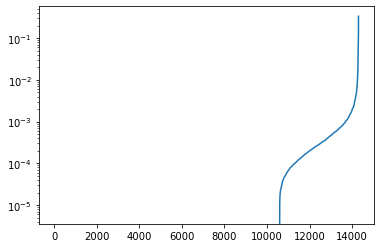

In [115]:
plt.plot(np.sort(abs_mean_shap))
plt.yscale('log')

Text(0, 0.5, 'Absolute average shap value')

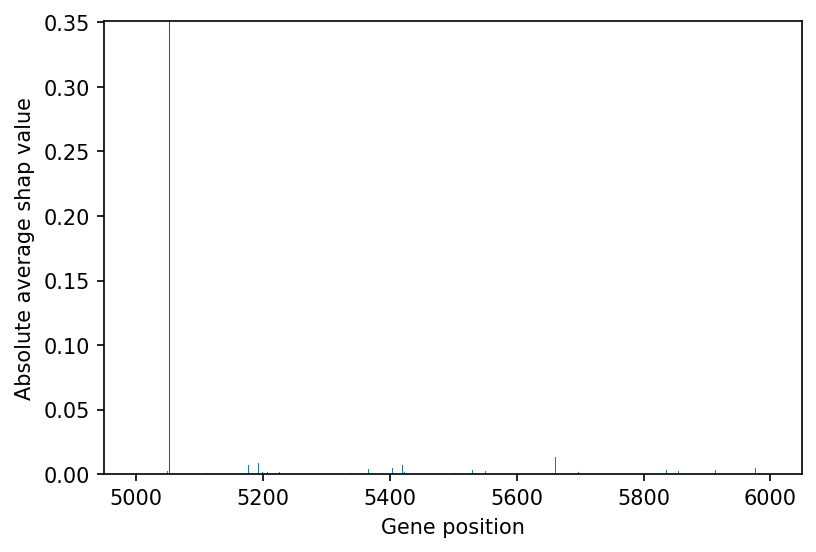

In [101]:
plt.figure(dpi=150)

plt.bar(np.arange(X.shape[1])[5000:6000], abs_mean_shap[5000:6000])
plt.axvline(x=5051, color="red", lw=0.5)
plt.xlabel("Gene position", )
plt.ylabel("Absolute average shap value")

In [89]:
np.where(abs_mean_shap>0.02)

(array([  410,   607,   675,   816,  1541,  1899,  2168,  2527,  2598,
         2757,  3963,  4294,  4659,  4947,  4950,  5722,  7806,  8017,
         8606, 10143, 11152, 12272, 12648, 12887, 13894, 14231]),)

In [86]:
X.columns[5040:5060][abs_mean_shap[5040:5060]>0.005]

Index(['CCDC170'], dtype='object')

In [94]:
abs_mean_shap[5722]

0.33434135

In [93]:
list(X.columns).index('EPHA1-AS1')

5722

# Interaction investigation
To find interaction values we must do an exponental computation. To be able to work with it we must eliminate all the superfluous variables in the model. We build a new model without the 10000 genes that arent used. 

In [128]:
(abs_mean_shap==0).sum()

10591

In [127]:
X_small = X.drop(X.iloc[:,np.where(abs_mean_shap==0)[0]], axis=1)

In [136]:
training_dmatrix = xgb.DMatrix(X_small.iloc[train_index_diff], label=Y[train_index_diff])
test_dmatrix = xgb.DMatrix(X_small.iloc[test_index_diff], label=Y[test_index_diff])

In [150]:
bst_small = xgb.train(params, training_dmatrix, num_boost_round=200)

[11:54:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [151]:
prediction_bst_small = bst_small.predict(test_dmatrix)

R^2 score is not well-defined with less than two samples.


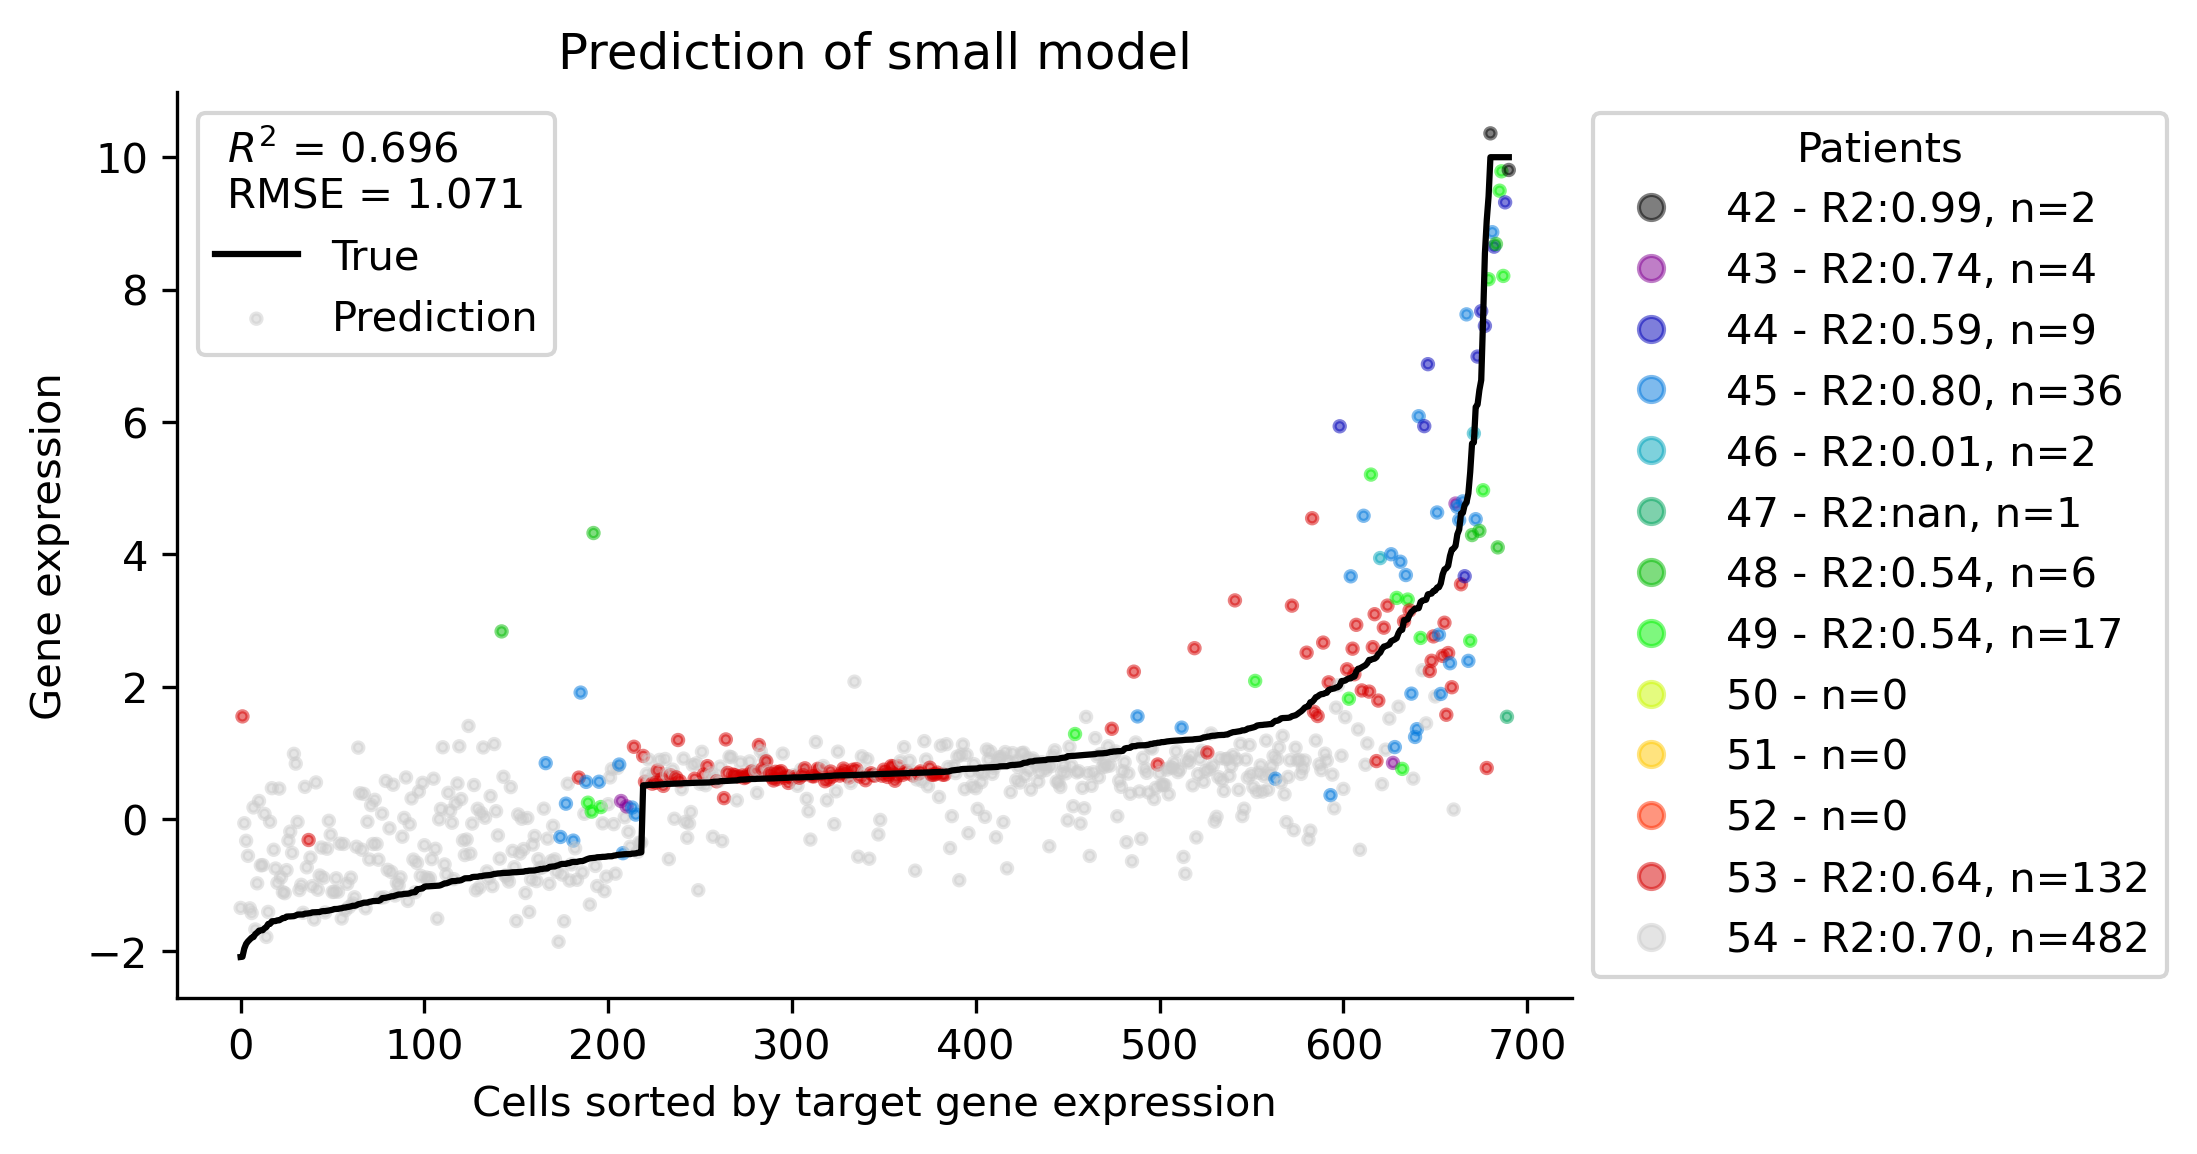

In [152]:
# Saved and loaded models makes the same predictions

fig, ax = plt.subplots(dpi=300)
modules.plot_prediction(Y[test_index_diff], 
                        prediction_bst_small,
                        c=np.array(patient_number)[test_index_diff],
                        cmap="nipy_spectral",
                        fig=fig, ax=ax, title=f"Prediction of small model")
plt.show()

In [153]:
explainer_small = shap.TreeExplainer(bst_small)

In [154]:
shap_vals_small = explainer_small.shap_values(X_small)

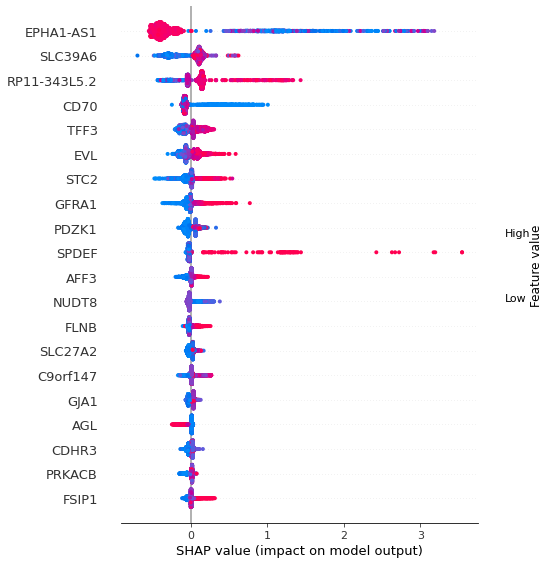

In [155]:
shap.summary_plot(shap_vals_small, X_small)

In [156]:
abs_mean_shap_small = np.abs(shap_vals_small).mean(axis=0)

Text(0, 0.5, 'Absolute average shap value')

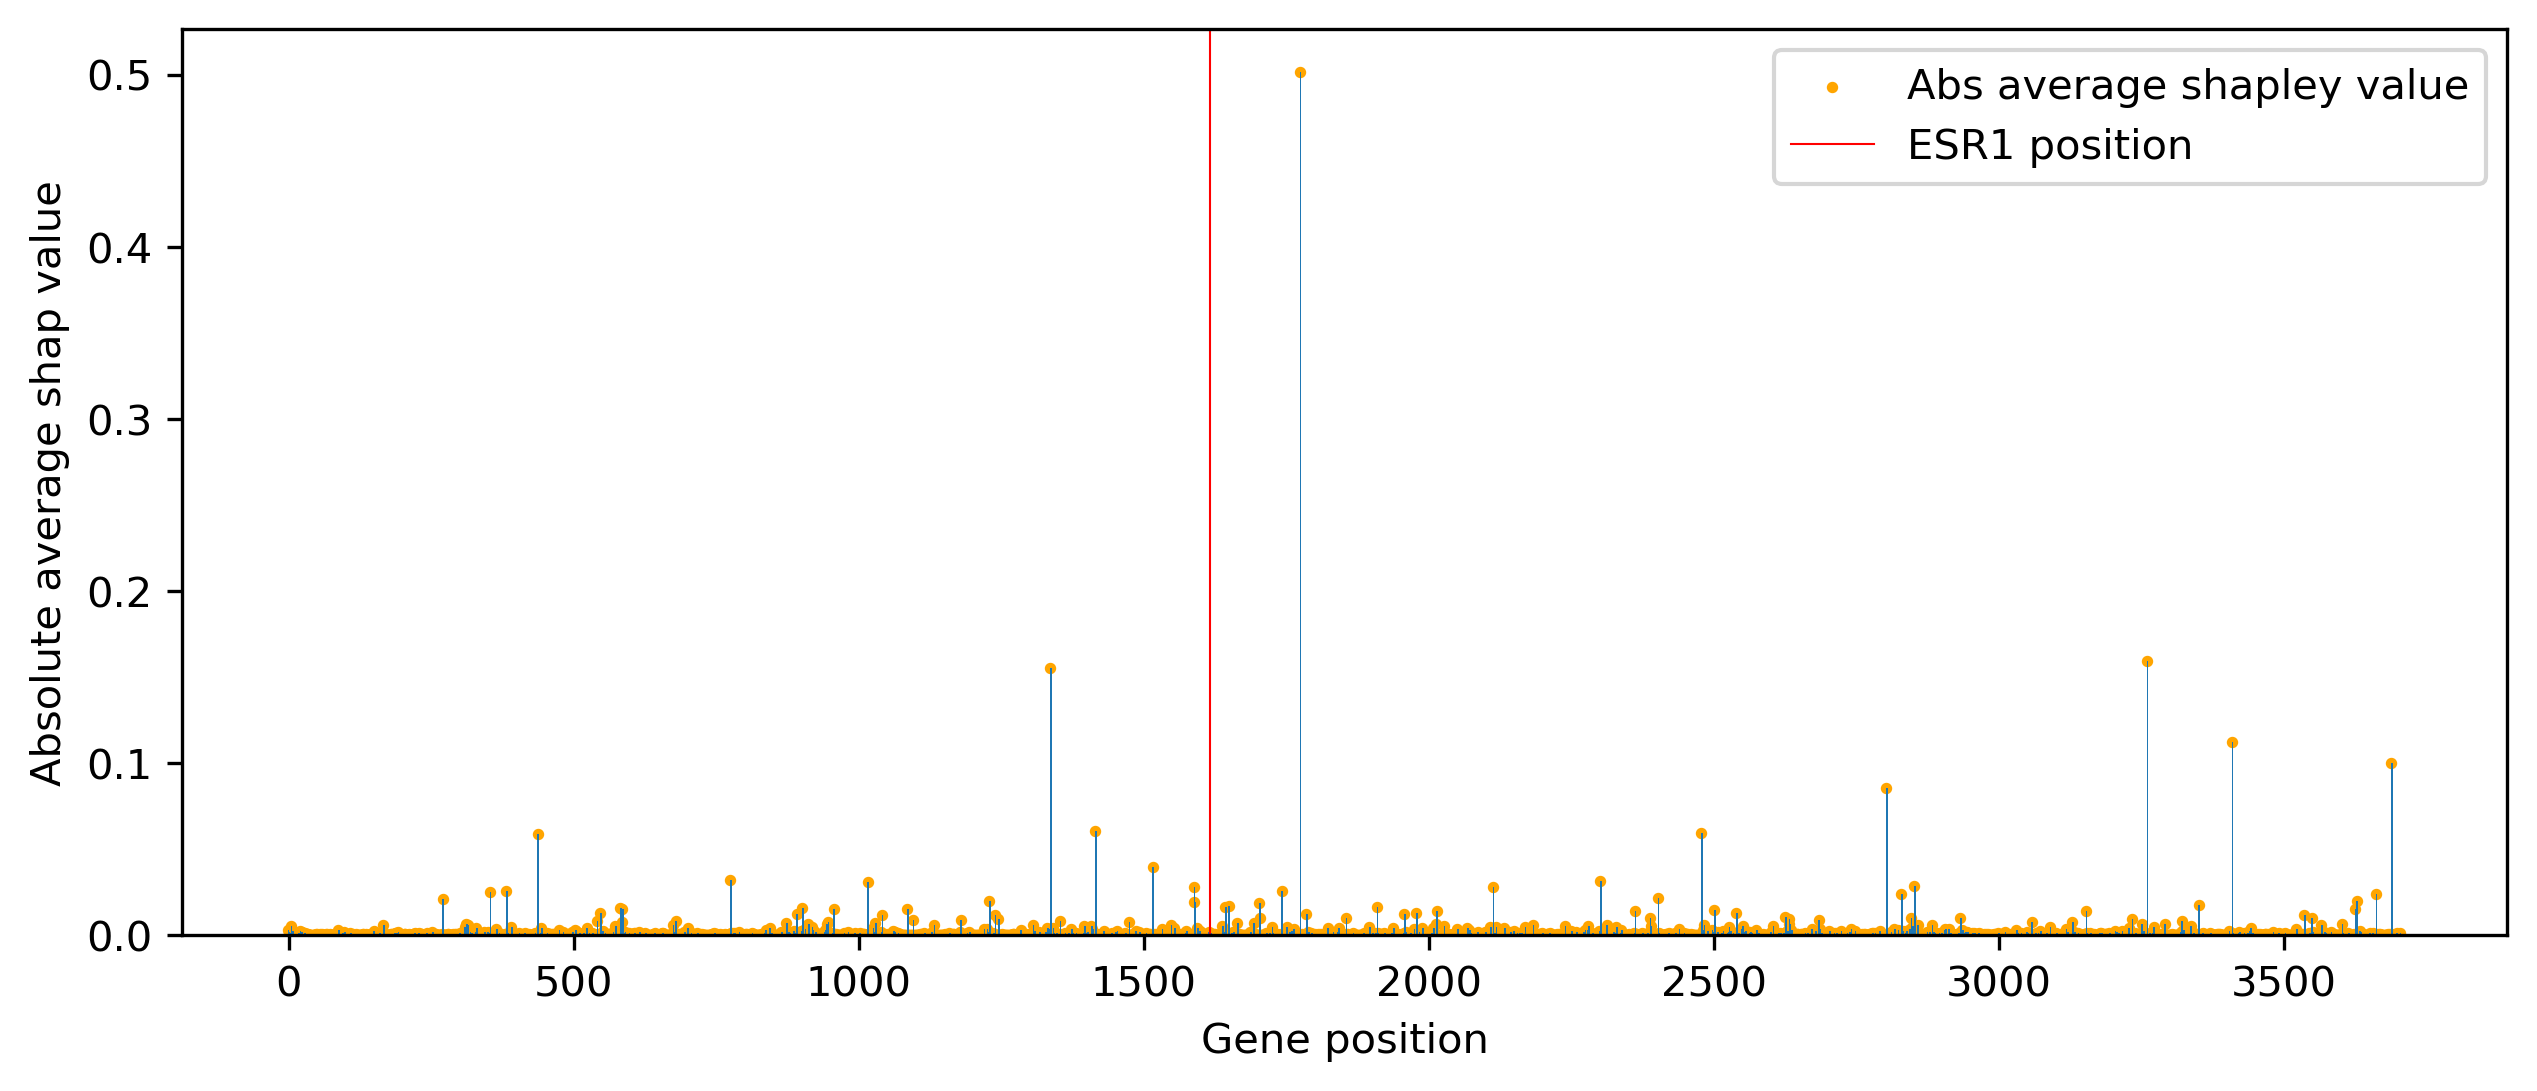

In [174]:
plt.figure(dpi=300, figsize=(10,4))
plt.scatter(np.arange(X_small.shape[1])-1, abs_mean_shap_small, s=3, color="orange", label="Abs average shapley value")
plt.bar(np.arange(X_small.shape[1]), abs_mean_shap_small, width=3)
plt.axvline(x=1616, color="red", lw=0.5, label="ESR1 position")
plt.xlabel("Gene position")
plt.legend()
plt.ylabel("Absolute average shap value")

In [166]:
current_smallest = 0
last_gene = ""
for i, c in enumerate(X_small.columns):
    if list(X.columns).index(c)< 5051:
        current_smallest = i
        last_gene = c

In [180]:
sum(abs_mean_shap_small>0.02)

24

,COL9A2,PRKACB,AGL,PDZK1,AFF3,FLNB,RP11-343L5.2,STC2,SPDEF,GJA1,...,RET,GFRA1,EVL,FSIP1,SLC27A2,SLC39A6,CD70,XBP1,PRR34-AS1,TFF3
Cell,,,,,,,,,,,,,,,,,,,,,
sc5rJUQ024_AGGTCATAGACTAGAT,-0.190702,-0.579769,-0.432650,-0.055467,-0.204006,-0.575189,-0.110508,-0.218818,-0.075204,-0.720143,...,-0.114275,-0.386642,0.405710,-0.089045,-0.128955,-0.565619,-0.127676,0.543527,-0.200839,-0.066312
sc5rJUQ024_CATGACAAGTACGACG,-0.139448,-0.459207,-0.201391,0.006705,-0.163431,0.016419,0.004908,0.080703,-0.090537,0.215707,...,0.036424,0.077331,-1.279651,-0.021462,-0.114611,-0.061543,-0.133019,-0.678188,-0.142605,-0.095680
sc5rJUQ024_GCGCGATCAACTGCTA,-0.215044,1.059428,0.467644,-0.066658,-0.178808,-1.067011,-0.249204,-0.400739,6.654084,-1.765283,...,-0.235876,-0.823362,0.171419,-0.136214,-0.061714,2.404323,-0.069852,-0.266385,-0.234325,2.118758
sc5rJUQ024_TCACAAGAGCCCTAAT,-0.172841,-0.253275,-0.392518,0.000107,-0.107638,-0.758896,-0.225392,-0.187787,2.968945,-1.504717,...,-0.154267,-0.625030,-0.204813,-0.093363,0.012978,-0.939493,-0.027306,0.612944,-0.191323,-0.120937
sc5rJUQ026_AACCATGGTCTCATCC,-0.116377,-0.254357,-0.174611,-0.043508,-0.057698,-0.202362,-0.028191,-0.118163,-0.207299,-0.143093,...,-0.052875,-0.030076,-0.562577,-0.063050,-0.101977,-0.204545,-0.120858,-0.542468,-0.121131,-0.129500


In [182]:
shap_interaction_values = explainer.shap_interaction_values(X_small.iloc[:5, abs_mean_shap_small>0.02])

XGBoostError: [12:17:26] /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/c_api/c_api_utils.h:117: Check failed: std::accumulate(shape.cbegin(), shape.cend(), 1, std::multiplies<>{}) == chunksize * rows (3125 vs. 1022164020) : 
Stack trace:
  [bt] (0) /data/severs/.conda/envs/ml/lib/libxgboost.so(+0xb448b) [0x7f3b9c97248b]
  [bt] (1) /data/severs/.conda/envs/ml/lib/libxgboost.so(+0xbbd18) [0x7f3b9c979d18]
  [bt] (2) /data/severs/.conda/envs/ml/lib/libxgboost.so(XGBoosterPredictFromDMatrix+0x7e2) [0x7f3b9c983ab2]
  [bt] (3) /data/severs/.conda/envs/ml/lib/python3.8/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f3f07f7ba4a]
  [bt] (4) /data/severs/.conda/envs/ml/lib/python3.8/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f3f07f7afea]
  [bt] (5) /data/severs/.conda/envs/ml/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x2f3) [0x7f3f07f90973]
  [bt] (6) /data/severs/.conda/envs/ml/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x10324) [0x7f3f07f91324]
  [bt] (7) /data/severs/.conda/envs/ml/bin/python(_PyObject_MakeTpCall+0x31e) [0x55df7e4b130e]
  [bt] (8) /data/severs/.conda/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x53cf) [0x55df7e5476ff]



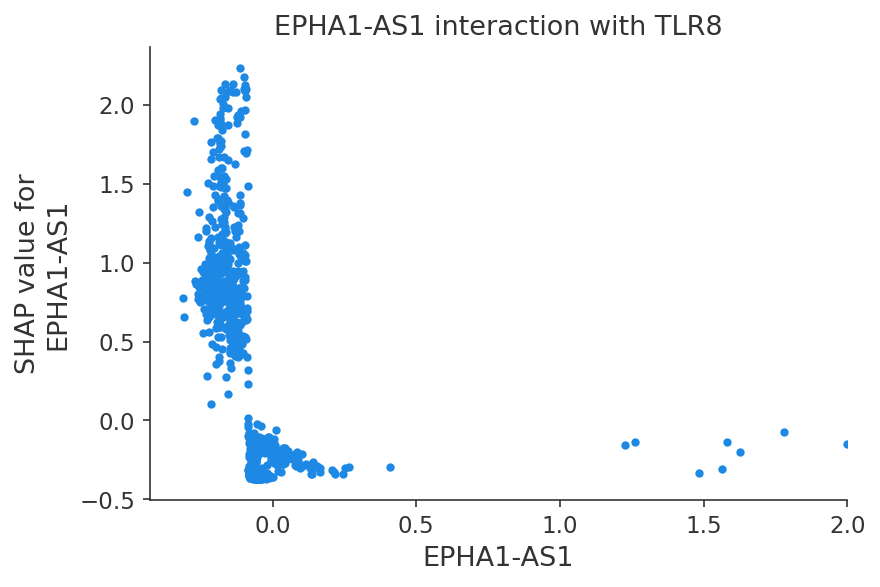

In [113]:
fig, ax = plt.subplots(dpi=150)
shap.dependence_plot(modules.get_index("EPHA1-AS1", X), 
                     shap_values=shap_vals, 
                     features=X, 
                     feature_names=X.columns, 
                     display_features=None, 
                     interaction_index=None, 
                     x_jitter=0, alpha=1, 
                     title="EPHA1-AS1 interaction with TLR8", xmin=None, xmax=2, ax=ax, show=True)


In [ ]:
avg_shap_vals = np.abs(shap_vals).mean(axis=0)

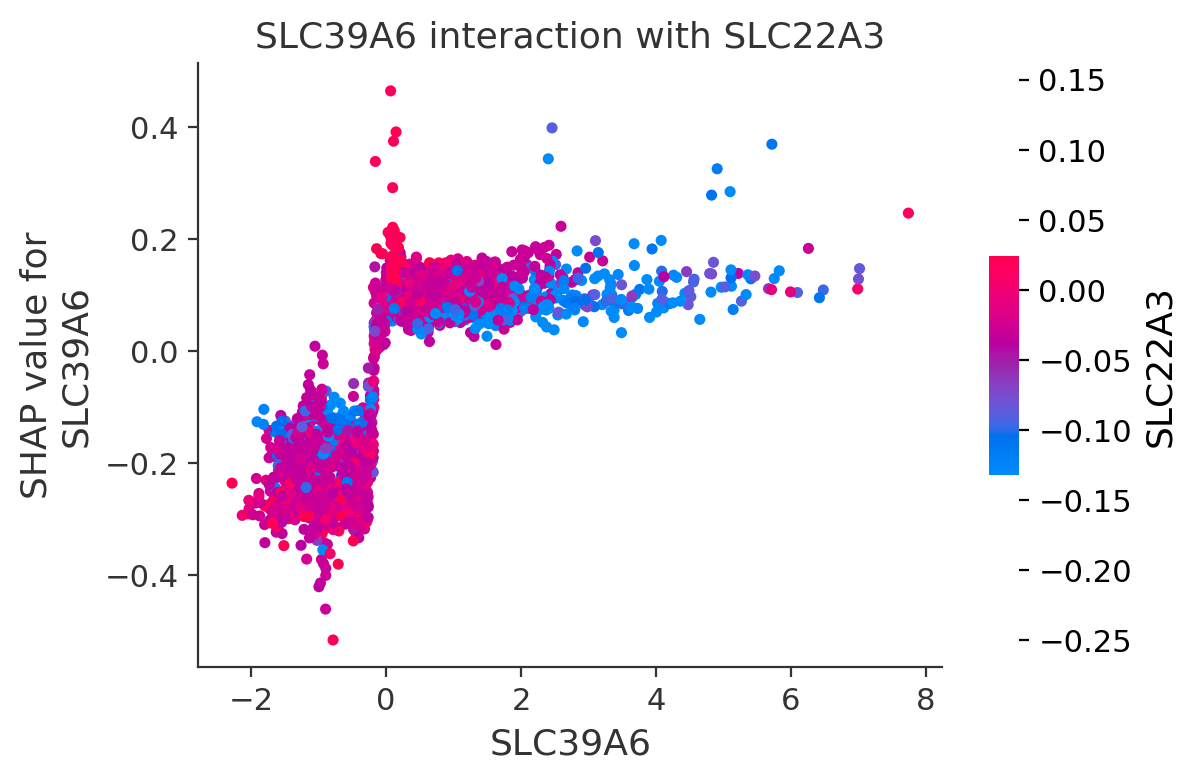

In [183]:
fig, ax = plt.subplots(dpi=200)
shap.dependence_plot(modules.get_index("SLC39A6", X), 
                     shap_values=shap_vals, 
                     features=X, 
                     feature_names=X.columns, 
                     display_features=None, 
                     interaction_index=modules.get_index("SLC22A3", X), 
                     x_jitter=0, alpha=1, 
                     title="SLC39A6 interaction with SLC22A3", xmin=None, xmax=None, ax=ax, show=True)


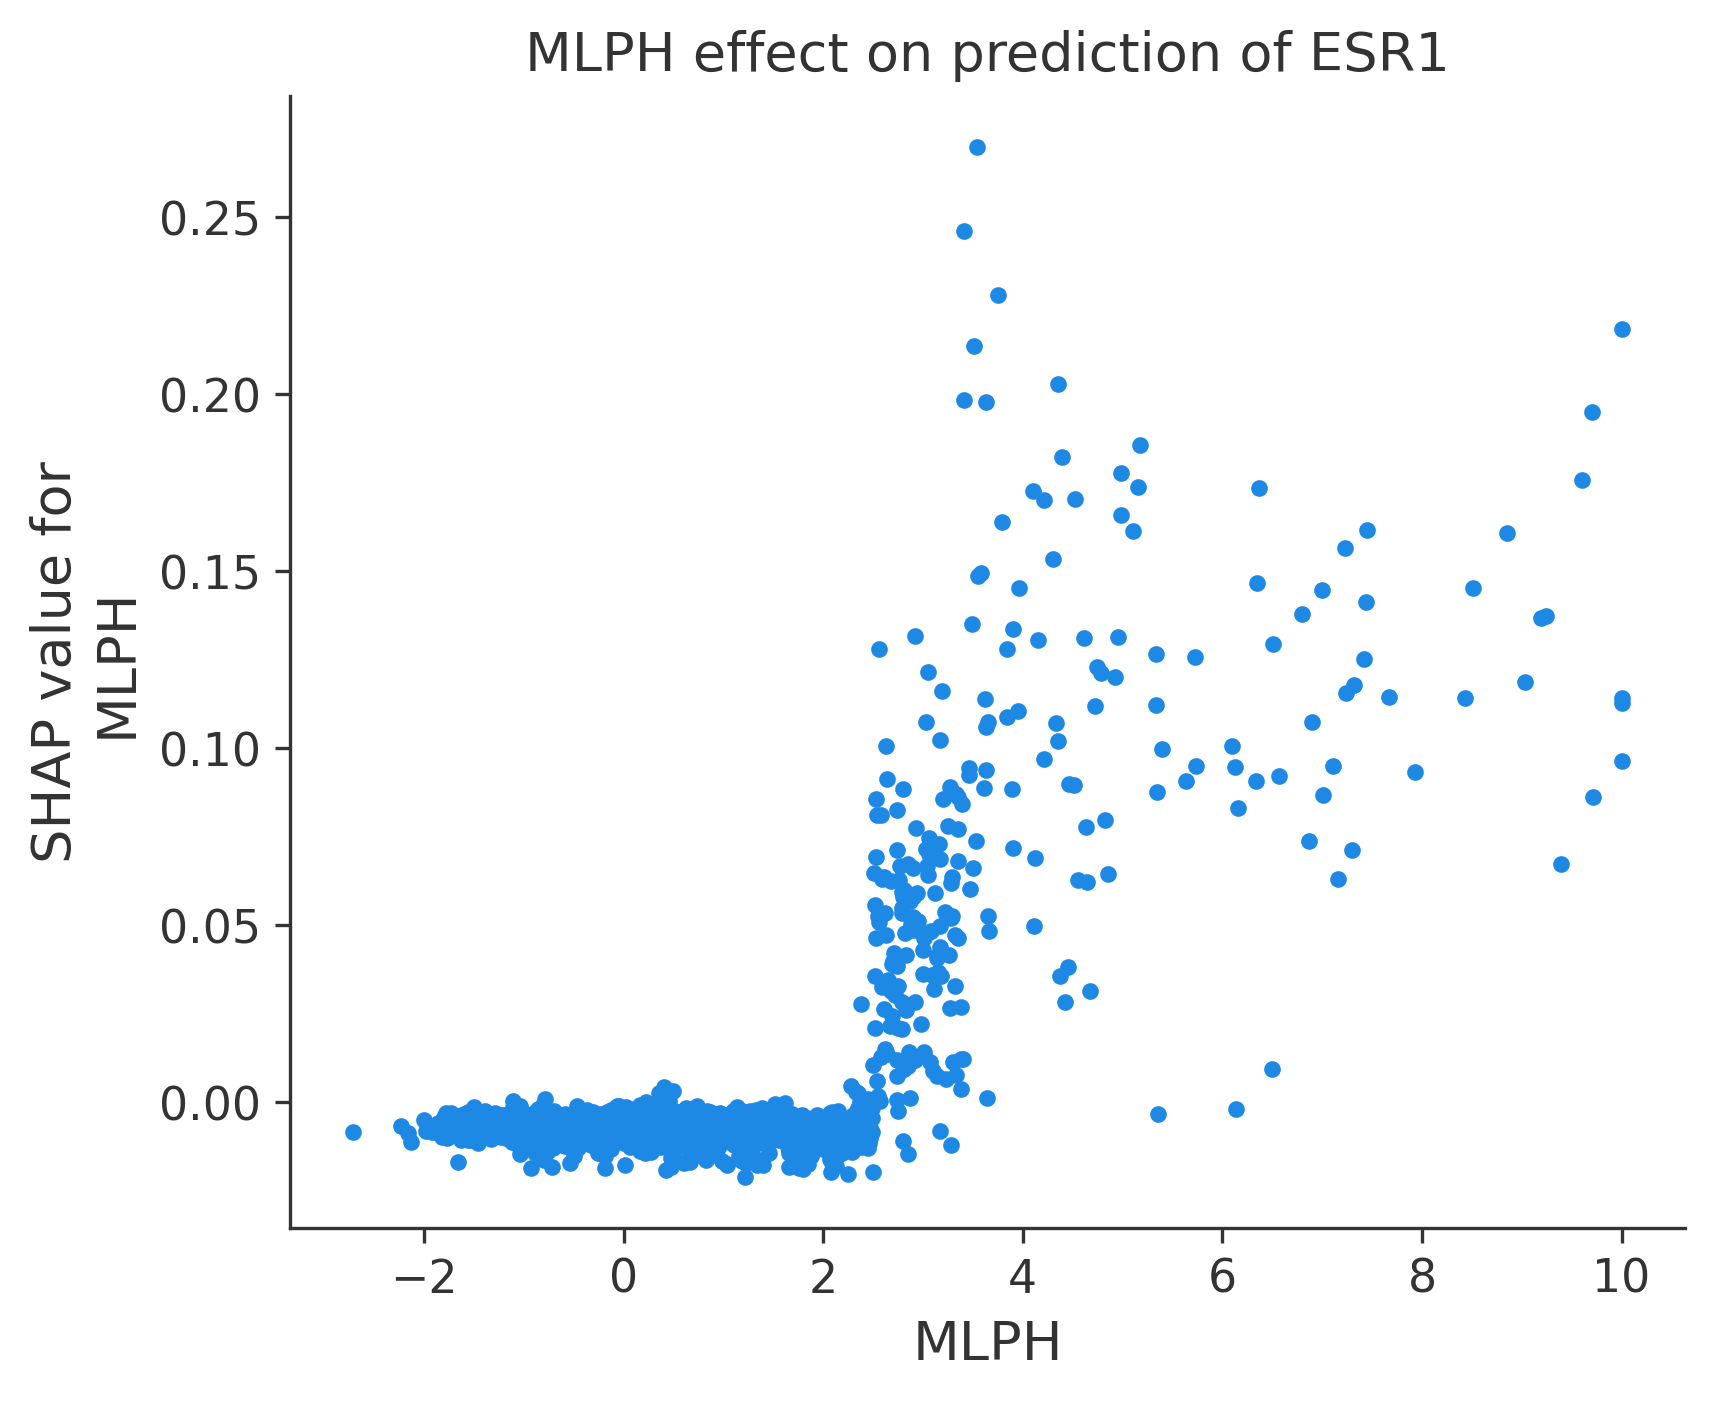

In [107]:
fig, ax = plt.subplots(dpi=300, figsize=(6,5))
shap.dependence_plot(modules.get_index("MLPH", X), 
                     shap_values=shap_vals, 
                     features=X, 
                     feature_names=X.columns, 
                     display_features=None, 
                     interaction_index=None, 
                     x_jitter=0, alpha=1, 
                     title="MLPH effect on prediction of ESR1", xmin=None, xmax=None, ax=ax, show=True)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


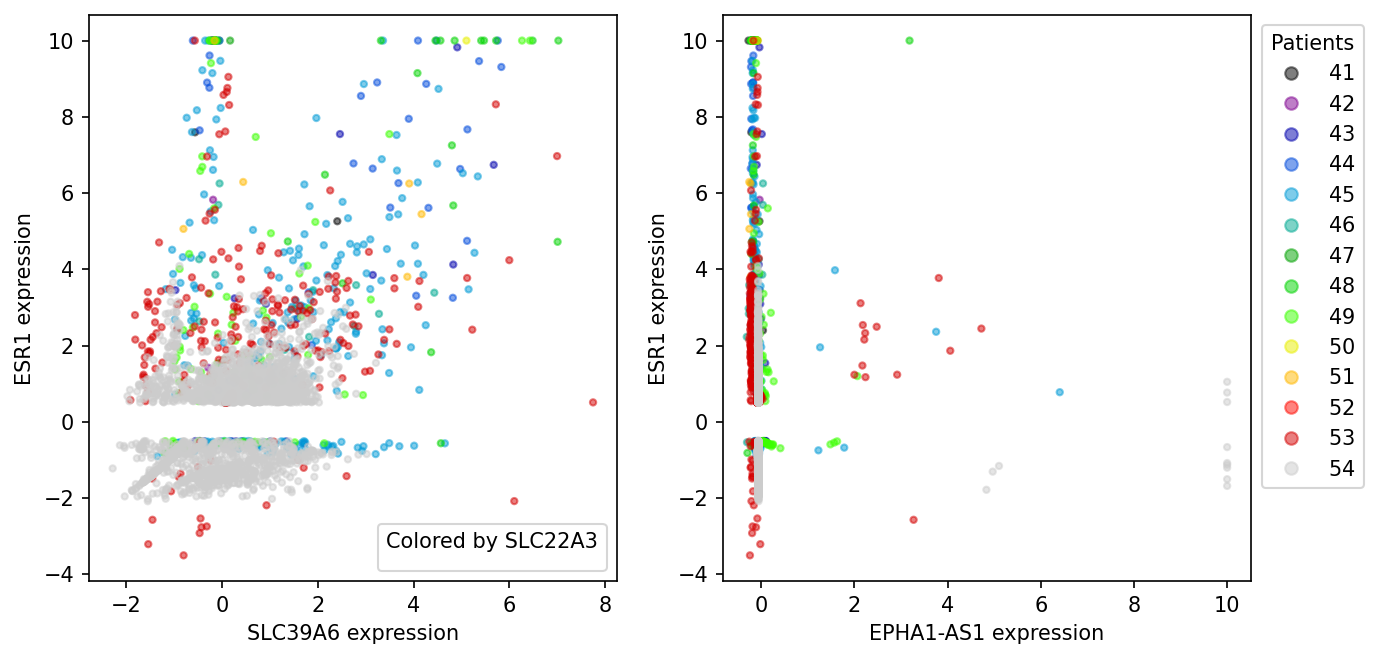

In [328]:
fig, axs = plt.subplots(1,2, dpi=150, figsize=(10,5))
axs[0].scatter(X["SLC39A6"], Y, marker=".", alpha=0.5,
               c=patient_number, cmap="nipy_spectral")
axs[0].set_ylabel("ESR1 expression")
axs[0].set_xlabel("SLC39A6 expression")
axs[0].legend(title="Colored by SLC22A3")

sc = axs[1].scatter(X["EPHA1-AS1"], Y, marker=".", alpha=0.5,
               c=patient_number, cmap="nipy_spectral")
axs[1].set_ylabel("ESR1 expression")
axs[1].set_xlabel("EPHA1-AS1 expression")
axs[1].legend(title="Colored by TLR8")

legend1 = axs[1].legend(*sc.legend_elements(),
                    bbox_to_anchor=(1, 1), title="Patients")

#fig.colorbar(cm.ScalarMappable(), ax=axs[1], ticks=None, label="Normalized interaction expression")
plt.show()

In [336]:
sum(abs(X["EPHA1-AS1"])<0.1)/len(X["EPHA1-AS1"])

0.8482220294882914

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


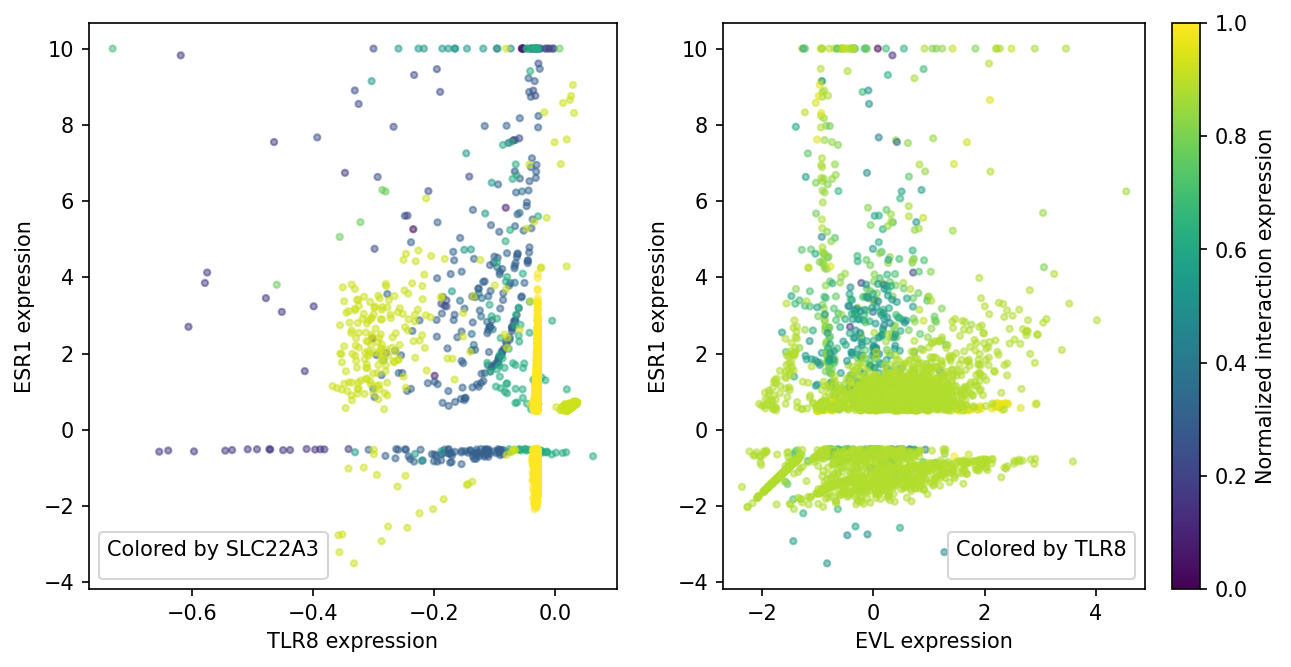

In [324]:
fig, axs = plt.subplots(1,2, dpi=150, figsize=(10,5))
axs[0].scatter(X["TLR8"], Y, marker=".", alpha=0.5, c=patient_number)
axs[0].set_ylabel("ESR1 expression")
axs[0].set_xlabel("TLR8 expression")
axs[0].legend(title="Colored by SLC22A3")

axs[1].scatter(X["EVL"], Y, marker=".", alpha=0.5, c=X["TLR8"])
axs[1].set_ylabel("ESR1 expression")
axs[1].set_xlabel("EVL expression")
axs[1].legend(title="Colored by TLR8")

fig.colorbar(cm.ScalarMappable(), ax=axs[1], ticks=None, label="Normalized interaction expression")
plt.show()

# SHAP Single predictions

In [ ]:
shap.plots.waterfall(shap_values[0])

# Cross validated result training set

In [180]:
cv_params = params.copy()
del cv_params["n_estimators"]

In [181]:
cv_result = xgb.cv(cv_params, training_dmatrix, num_boost_round=200, verbose_eval=50)

[0]	train-rmse:1.93915+0.05148	test-rmse:1.95240+0.10361
[50]	train-rmse:0.60995+0.01203	test-rmse:1.17800+0.06160
[100]	train-rmse:0.34432+0.00961	test-rmse:1.13043+0.05442
[150]	train-rmse:0.22127+0.00399	test-rmse:1.12405+0.05323
[199]	train-rmse:0.14840+0.00288	test-rmse:1.12185+0.05179


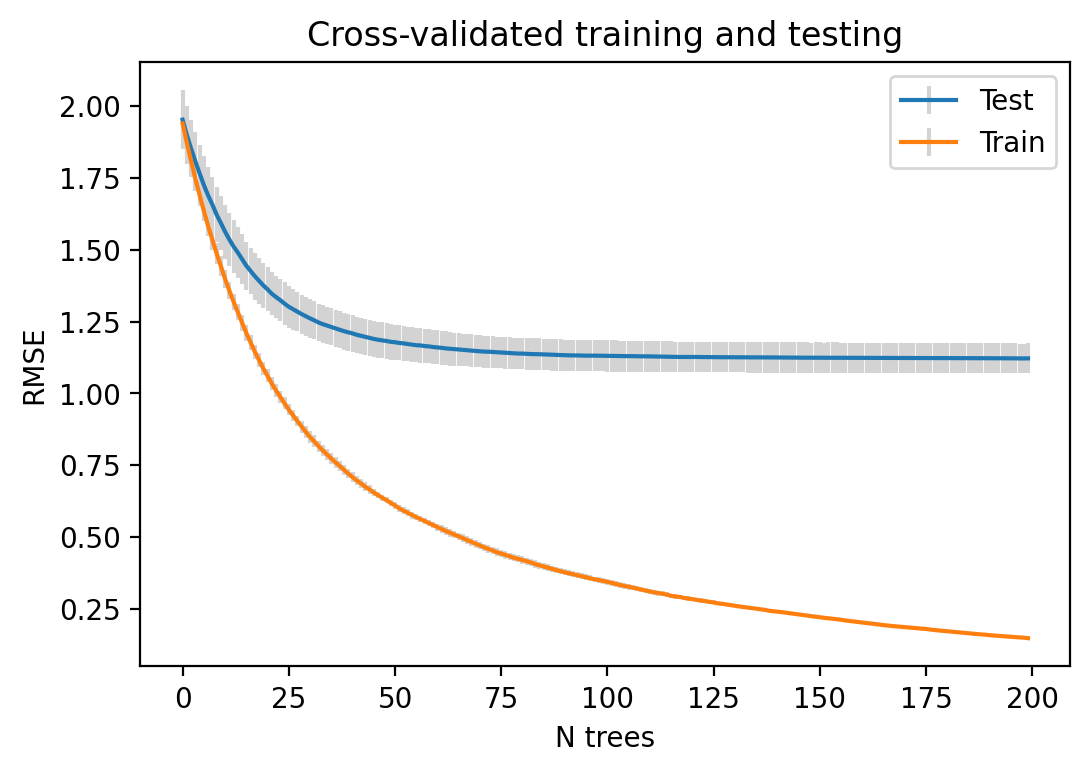

In [182]:
plt.figure(dpi=200)
plt.errorbar(np.arange(200), cv_result["test-rmse-mean"], cv_result["test-rmse-std"],
             linestyle='-', marker=None, label="Test", ecolor="lightgrey")
plt.errorbar(np.arange(200), cv_result["train-rmse-mean"], cv_result["train-rmse-std"],
             linestyle='-', marker=None, label="Train", ecolor="lightgrey")
plt.legend()
plt.xlabel("N trees")
plt.ylabel("RMSE")
plt.title("Cross-validated training and testing")
plt.show()

# All data

In [288]:
train_ind_all = pd.read_csv("/data/severs/trainind_patient_strat.csv")["Resample1"].values -1

In [293]:
test_index_all = np.zeros(df.shape[0]-train_ind_all.shape[0], dtype=int)
i = 0
for idk in range(df.shape[0]):
    if idk not in train_ind_all:
        test_index_all[i] = idk
        i += 1

In [295]:
model_all = xgb.XGBRegressor(**params)

In [299]:
train_hist = model_all.fit(df.drop("ESR1", axis=1).iloc[train_ind_all], df["ESR1"][train_ind_all])

In [300]:
prediction_all = model_all.predict(df.drop("ESR1", axis=1).iloc[test_index_all])

Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.


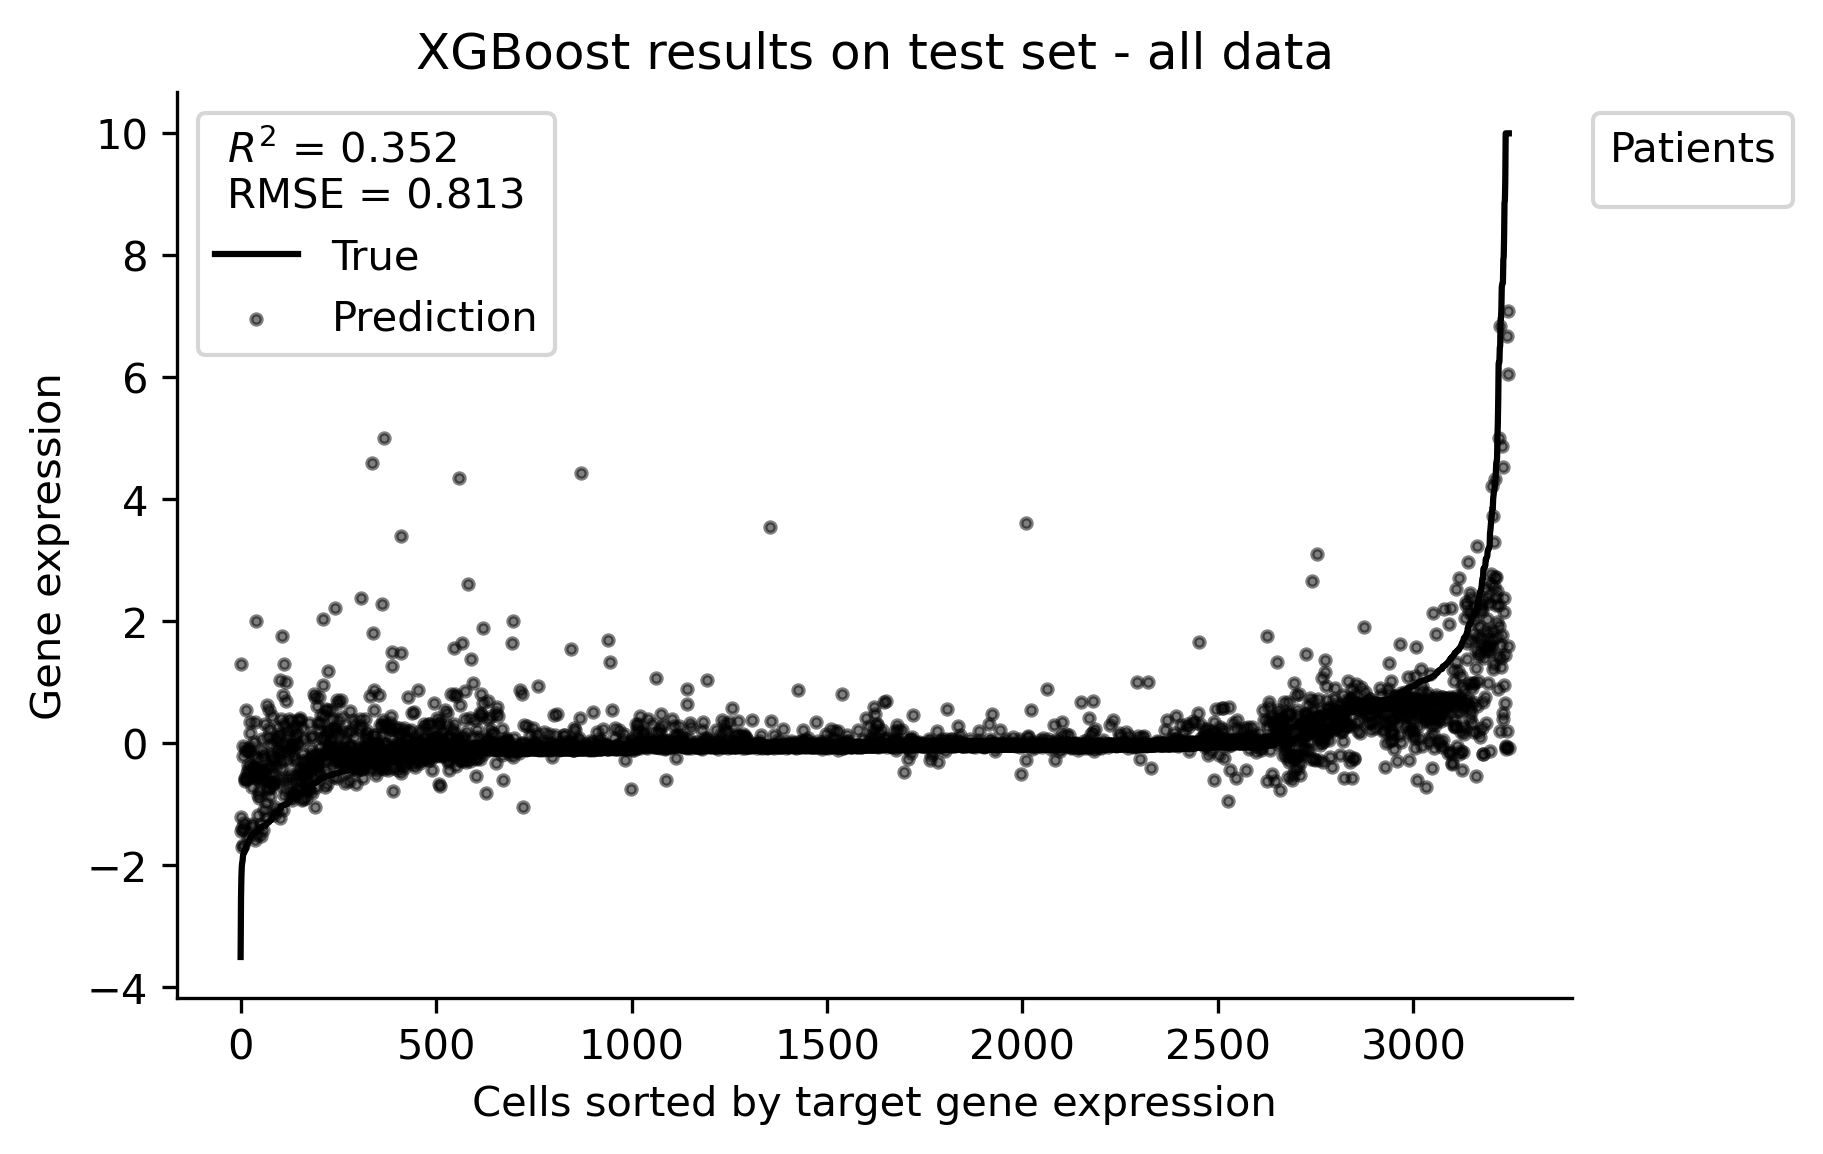

In [354]:
fig, ax = plt.subplots(dpi=300)
modules.plot_prediction(df["ESR1"][test_index_all], 
                        prediction_all,
                        #c=np.array(patient_number)[test_index_all],
                        cmap="nipy_spectral",
                        fig=fig, ax=ax, title="XGBoost results on test set - all data")
plt.show()